In [1]:
!nvidia-smi

Sun Dec 10 14:02:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   33C    P8               5W / 320W |      1MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Import fastai Text library

In [2]:
from fastai.text.all import *

## Dataset

The dataset we are using is yelp50k, a dataset of 50000 comments on yelp (now comments on google maps reviews).

In [3]:
path = untar_data('http://codeandbeer.org/mydata/yelp50k_dataset.tgz')

In [4]:
path.ls()

(#2) [Path('/root/.fastai/data/yelp50k_dataset/reviews_50k.json'),Path('/root/.fastai/data/yelp50k_dataset/models')]

Data is in JSON format, although not a single JSON object, but a JSON object by line. We use pandas to import it.

In [5]:
df = pd.read_json(path/"reviews_50k.json", lines=True)

In [6]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1,6,1,0,Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.,2013-05-07 04:34:36
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5,0,0,0,"I *adore* Travis at the Hard Rock's new Kelly Cardenas Salon! I'm always a fan of a great blowout and no stranger to the chains that offer this service; however, Travis has taken the flawless blowout to a whole new level! \n\nTravis's greets you with his perfectly green swoosh in his otherwise perfectly styled black hair and a Vegas-worthy rockstar outfit. Next comes the most relaxing and incredible shampoo -- where you get a full head message that could cure even the very worst migraine in minutes --- and the scented shampoo room. Travis has freakishly strong fingers (in a good way) a...",2017-01-14 21:30:33
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5,3,0,0,"I have to say that this office really has it together, they are so organized and friendly! Dr. J. Phillipp is a great dentist, very friendly and professional. The dental assistants that helped in my procedure were amazing, Jewel and Bailey helped me to feel comfortable! I don't have dental insurance, but they have this insurance through their office you can purchase for $80 something a year and this gave me 25% off all of my dental work, plus they helped me get signed up for care credit which I knew nothing about before this visit! I highly recommend this office for the nice synergy th...",2016-11-09 20:09:03
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,0,0,0,"Went in for a lunch. Steak sandwich was delicious, and the Caesar salad had an absolutely delicious dressing, with a perfect amount of dressing, and distributed perfectly across each leaf. I know I'm going on about the salad ... But it was perfect.\n\nDrink prices were pretty good.\n\nThe Server, Dawn, was friendly and accommodating. Very happy with her.\n\nIn summation, a great pub experience. Would go again!",2018-01-09 20:56:38
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1,7,0,0,"Today was my second out of three sessions I had paid for. Although my first session went well, I could tell Meredith had a particular enjoyment for her male clients over her female. However, I returned because she did my teeth fine and I was pleased with the results. When I went in today, I was in the whitening room with three other gentlemen. My appointment started out well, although, being a person who is in the service industry, I always attend to my female clientele first when a couple arrives. Unbothered by those signs, I waited my turn. She checked on me once after my original 30 min...",2018-01-30 23:07:38


We drop unnecessary data (columns we won't be using for the model).

In [8]:
df.drop(['review_id','user_id','business_id','date','useful','funny','cool'], axis=1, inplace=True)

KeyError: "['review_id' 'user_id' 'business_id' 'date' 'useful' 'funny' 'cool'] not found in axis"

We keep only text and stars (value of the review).

In [10]:
df.dtypes

stars     int64
text     object
dtype: object

## Train/validation split

We will use a 80/20 split.

In [11]:
cut = int(0.8*len(df))

In [12]:
splits = [list(range(cut)), list(range(cut,len(df)))]

The trasnformations we will implement to create the DataLoaders. 

In [13]:
tfms = [attrgetter("text"), Tokenizer.from_df(1), Numericalize()]

In [14]:
dataset = Datasets(df, [tfms], splits=splits, dl_type=LMDataLoader)

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


By using the device parameter we can move from one GPU to another (cuda:0 to cuda:1), for example.

In [15]:
dl = dataset.dataloaders(bs=104, seq_len=72, device=torch.device('cuda:0'))

In [16]:
dl.show_batch()

,text,text_
0,xxbos i feel so lucky to have found this fitness center . xxmaj it had been five years since i had a gym membership . i could n't stand the thought of spending time in a stinky overcrowded facility ran by stuck up employees who only speak to you if you approach them first . xxmaj the gym offers brand new state of the art equipment including interactive machines which helps keeps,i feel so lucky to have found this fitness center . xxmaj it had been five years since i had a gym membership . i could n't stand the thought of spending time in a stinky overcrowded facility ran by stuck up employees who only speak to you if you approach them first . xxmaj the gym offers brand new state of the art equipment including interactive machines which helps keeps you
1,"we had a great meal with even better service last night at xxmaj the xxmaj keg . xxmaj although my wife 's filet was a bit undercooked , they corrected the steak and then comped our wine and dessert . xxmaj nice touch . xxmaj and the atmosphere on the patio was great . xxbos xxmaj this place is the bomb , fresh and delicious it ca n't get any better than","had a great meal with even better service last night at xxmaj the xxmaj keg . xxmaj although my wife 's filet was a bit undercooked , they corrected the steak and then comped our wine and dessert . xxmaj nice touch . xxmaj and the atmosphere on the patio was great . xxbos xxmaj this place is the bomb , fresh and delicious it ca n't get any better than this"
2,". xxmaj they has a seafood pizza with shrimp and it was for reals so heavenly * drool * . xxmaj also , the crab was great , the duck was yummy and honestly , i did n't have anything that i did n't like . \n\n\n i really want to come back here for dinner sometime ! xxmaj so far it 's been my fave buffet in xxmaj vegas . xxmaj","xxmaj they has a seafood pizza with shrimp and it was for reals so heavenly * drool * . xxmaj also , the crab was great , the duck was yummy and honestly , i did n't have anything that i did n't like . \n\n\n i really want to come back here for dinner sometime ! xxmaj so far it 's been my fave buffet in xxmaj vegas . xxmaj i"
3,"xxbos xxmaj i 've had dinner at the xxmaj river xxmaj cafe twice . xxmaj both times xxmaj i 've left thinking the place was just ok , but at the same time xxmaj i 'd recommend the place , mainly because of its setting . \n\n xxmaj the atmosphere is excellent . xxmaj the restaurant is set in xxmaj prince 's xxmaj island xxmaj park , a picturesque park right off","xxmaj i 've had dinner at the xxmaj river xxmaj cafe twice . xxmaj both times xxmaj i 've left thinking the place was just ok , but at the same time xxmaj i 'd recommend the place , mainly because of its setting . \n\n xxmaj the atmosphere is excellent . xxmaj the restaurant is set in xxmaj prince 's xxmaj island xxmaj park , a picturesque park right off the"
4,the mix ! xxbos xxmaj too bad i ca n't give a 0 star have to give one . i will never eat here again . xxmaj it took almost 5 mins for me to be helped while there was 4 workers in the kitchen . i was n't even greated nor was there an apology for me having to wait . xxmaj and when i got my pizza the cuts were,mix ! xxbos xxmaj too bad i ca n't give a 0 star have to give one . i will never eat here again . xxmaj it took almost 5 mins for me to be helped while there was 4 workers in the kitchen . i was n't even greated nor was there an apology for me having to wait . xxmaj and when i got my pizza the cuts were so
5,". xxmaj each townhome has its own garage and can hold one car ( one bedroom unit ) or 2 cars ( 2 / 3 bedroom unit ) . xxmaj office staff is always friendly and will act immediately on most repairs or complaints . xxmaj i 'd say the only challenges here are the flights of steps you have to climb in the apartments , moderate amount of noise through the","xxmaj each townhome has its own garage and can hold one car ( one bedroom unit ) or 2 cars ( 2 / 3 bedroom unit ) . xxmaj office staff 

## Neural Network Creation 

We create a NeuralNetwork, based on the LSTM model. We transform it to fp16 (FloatingPoint16) datatype to speed up its training. 

In [17]:
learn = language_model_learner(dl, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

In [18]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(25888, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(25888, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0-2): 3 x RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=25888, bias=True)
    (output_dp): RNNDropout()
  )
)

## Neural Network training

Finding the learning rate

SuggestedLRs(valley=0.004365158267319202)

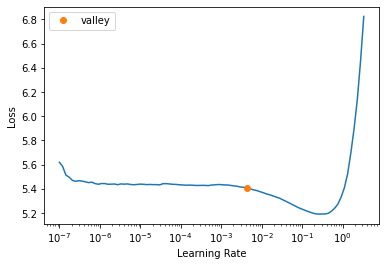

In [19]:
learn.lr_find()

Train for 4 epochs

In [20]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.542834,4.198959,0.259701,66.616936,01:47
1,4.306219,4.029896,0.271804,56.255047,01:46
2,4.242209,3.988303,0.274875,53.963245,01:46
3,4.222728,3.982563,0.275352,53.654400,01:46


## Inference

We can use our model to generate text based on an initial sentence.

In [21]:
initial_text = "This restaurant is great because"
words = 40 

In [22]:
learn.predict(initial_text, words, temperature=0.75)

'This restaurant is great because of the variety of it available . The Yonge Street Hotel is a nice and efficient location , but the hotel is a great place to watch the night . It has a patio and'

In [23]:
learn.predict(initial_text, words, temperature=0.75)

'This restaurant is great because the staff at Tower Palace is gentle , when the food is delicious and the menu is simple and tasty . The menu is always fresh and tasty , and the service is good . To'

In [24]:
learn.predict(initial_text, words, temperature=0.75)

'This restaurant is great because it is not a Chipotle . The staff is very friendly and friendly , and there is a nice atmosphere and friendly staff . Lots of coffee in the area . Their staff is very friendly'

In [25]:
learn.predict(initial_text, words, temperature=0.75)

'This restaurant is great because it gets a great place to visit . There is a huge selection of tennis courts in the United States . This place is very good and also has a nice touch with the Indian'

In [26]:
learn.predict(initial_text, words, temperature=0.25)

'This restaurant is great because of the fact that the French Toast is a great place to go back to the French Toast . The French toast is a great place to eat . The French toast'